In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchsummary import summary
import numpy as np
import pandas as pd
import re
import glob
import os 
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm

device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")# 'cuda:0'

In [2]:
# build the dataset
class MyDataset(Dataset):
    def __init__(self,root_dir):
        self.root_dir=root_dir
        
        self.filenames=sorted(glob.glob(os.path.abspath("{root}/*.csv".format(root=root_dir))))
        self.waveforms=self.getwaveforms(self.filenames)
        
    def getwaveforms(self,files):
        files_num=len(files)
        waveforms=[]
        print("building the dataset...")
        for i in tqdm(range(files_num)):
            waveforms.append(torch.tensor([pd.read_csv(files[i]).iloc[:,0].values]).to(torch.float32))
#         waveforms=torch.tensor(waveforms).to(torch.float32)
        return waveforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self,idx):
        label=re.findall(r"\\\d+-",self.filenames[idx])#re.findall(r"/\d+-",self.filenames[idx])
        return self.waveforms[idx],int(label[0][1:-1])

In [3]:
dataset=MyDataset("F:/Python/data processing/Tea_Data_Csv")
dataset_len=len(dataset)
trainset_len=int(0.05*dataset_len)
trainset,testset=torch.utils.data.random_split(dataset,[trainset_len,dataset_len-trainset_len])
# trainset, testset = torch.utils.data.random_split(dataset, [1, 199])
def pad_sequence(batch):
    batch=[item.t() for item in batch]
    batch=torch.nn.utils.rnn.pad_sequence(batch,batch_first=True,padding_value=0.)
    return batch.permute(0,2,1)

def collate_fn(batch):
    tensors,targets=[],[]
    for waveform,label in batch:
        tensors+=[waveform]
        targets+=[torch.tensor(label)]
    tensors=pad_sequence(tensors)
    targets=torch.stack(targets)
    return tensors,targets

batch_size=64
trainloader=DataLoader(trainset,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)
testloader=DataLoader(testset,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)

building the dataset...


  0%|                                                                                          | 0/500 [00:00<?, ?it/s]C:\Users\Administrator\AppData\Local\Temp\ipykernel_23428\1325889612.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  waveforms.append(torch.tensor([pd.read_csv(files[i]).iloc[:,0].values]).to(torch.float32))
100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 905.60it/s]


In [4]:
# define the model
class M(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, 8, kernel_size=5, stride=stride)
        self.bn1 = nn.BatchNorm1d(8)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(16)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(16, 32, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(32)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(32, 64, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(64)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(64, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

model = M(n_input=1, n_output=10)
model=model.to(device)
summary(model,(1,5120))

print(model)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
n = count_parameters(model)
print("Number of parameters: %s" % n)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 8, 5116]              48
       BatchNorm1d-2              [-1, 8, 5116]              16
         MaxPool1d-3              [-1, 8, 1279]               0
            Conv1d-4             [-1, 16, 1277]             400
       BatchNorm1d-5             [-1, 16, 1277]              32
         MaxPool1d-6              [-1, 16, 319]               0
            Conv1d-7              [-1, 32, 317]           1,568
       BatchNorm1d-8              [-1, 32, 317]              64
         MaxPool1d-9               [-1, 32, 79]               0
           Conv1d-10               [-1, 64, 77]           6,208
      BatchNorm1d-11               [-1, 64, 77]             128
        MaxPool1d-12               [-1, 64, 19]               0
           Linear-13                [-1, 1, 10]             650
Total params: 9,114
Trainable params: 9

In [5]:
# def train(model,epoch,log_interval):
#     model.train()
#     for batch_idx, (data, target) in enumerate(trainloader):
#         data=data.to(device).to(torch.float32)
#         target=target.to(device)
#         output = model(data)
#         loss = F.nll_loss(output.squeeze(), target)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         if batch_idx % log_interval == 0:
#             print(f"\tLoss: {loss.item():.6f}")
#         losses.append(loss.item())

In [6]:
def number_of_correct(pred, target):
#     count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
#     find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


# def test(model, epoch):
#     model.eval()
#     correct = 0
#     for data, target in testloader:

#         data = data.to(torch.float32).to(device)
#         target=target.to(device)
# #         apply transform and model on whole batch directly on device
#         output = model(data)

#         pred = get_likely_index(output)
#         correct += number_of_correct(pred, target)   
  

#     print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(testloader.dataset)} ({100. * correct / len(testloader.dataset):.0f}%)\n")
#     return correct/(len(testloader.dataset))

In [7]:
def myonetest(model, epoch):
    model.eval().cpu()
    correct = 0
    onepredict=[]
    onetarget=[]
    for data, target in testloader:

        data = data.to(torch.float32)

#         apply transform and model on whole batch directly on device
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)   
#         update progress bar
#         pbar.update(pbar_update)
        pred=list(pred.squeeze().numpy())
        target=list(target.squeeze().numpy())
        onepredict += pred
        onetarget+=target
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(testloader.dataset)} ({100. * correct / len(testloader.dataset):.0f}%)\n")
    return (correct/(len(testloader.dataset)),onepredict,onetarget)


Test Epoch: 2	Accuracy: 450/475 (95%)

[[48  0  0  0  0  0  1  0  0  0]
 [ 1 46  0  0  0  0  0  0  0  0]
 [ 1  0 44  0  1  0  3  0  0  0]
 [ 0  0  0 40  0  2  2  2  0  0]
 [ 2  1  0  0 43  0  0  0  0  0]
 [ 0  0  0  0  1 47  0  0  0  0]
 [ 0  0  0  0  0  1 41  0  1  2]
 [ 0  0  0  0  0  0  2 44  0  0]
 [ 1  0  0  0  0  0  0  0 48  0]
 [ 0  0  0  0  0  0  0  0  1 49]]
[['48' '0' '0' '0' '0' '0' '1' '0' '0' '0']
 ['1' '46' '0' '0' '0' '0' '0' '0' '0' '0']
 ['1' '0' '44' '0' '1' '0' '3' '0' '0' '0']
 ['0' '0' '0' '40' '0' '2' '2' '2' '0' '0']
 ['2' '1' '0' '0' '43' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '1' '47' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '1' '41' '0' '1' '2']
 ['0' '0' '0' '0' '0' '0' '2' '44' '0' '0']
 ['1' '0' '0' '0' '0' '0' '0' '0' '48' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0' '1' '49']]


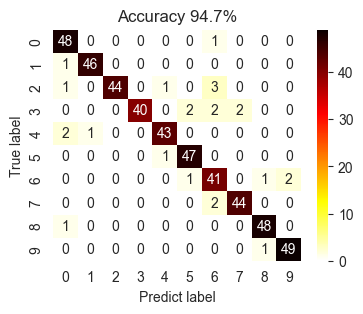

In [8]:
def myConfusionMatrixHeatmap(y_pred,y_true):
    import numpy
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt

    
    sns.set({'figure.figsize': [4,3]})
    f, ax = plt.subplots()
#     y_true = [0, 0, 1, 2, 1, 2, 0, 2, 2, 0, 1, 1]
#     y_pred = [1, 0, 1, 2, 1, 0, 0, 2, 2, 0, 1, 1]
    C2 = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    C2_Acc=C2/20*100
    annot=numpy.zeros(C2.shape).astype(int).astype(str)
    trueSum=0
    for i in range(10):
        trueSum+=C2[i][i];
        for j in range(10):
            if(C2[i][j]!=0):
                annot[i][j]="{}".format(C2[i][j])

    print(C2)
    print(annot)
    sns.heatmap(C2, annot=annot, fmt="", ax=ax, cmap="hot_r")  

    ax.set_title('Accuracy {:.1f}%'.format(trueSum/(dataset_len-trainset_len)*100)) 
    ax.set_xlabel('Predict label')  
    ax.set_ylabel('True label')  
    plt.show()
def load_model(path):
    net = torch.load(path)
    return net

model = load_model("F:/Python/jupyter notebook/1dcnn rnn/model.pkl")
_, onepredict, onetarget = myonetest(model, 2)
myConfusionMatrixHeatmap(onepredict,onetarget)